# Numba
# A LLVM-based Python JIT Compiler
### Siu Kwan Lam
### Antoine Pitrou, Stanley Seibert

#### siu@continuum.io

## Introduction

### Numba
* A Python JIT that targets scientific Python code
* JIT as a library 
    * We don't replace CPython 
* Targets a (expanding) subset of Python
* The Goal
    * Improve CPython performance in scientific computation
    * Scale Python from prototype to production

## Python

* Easy to read
* Dynamically typed, interpreted language
* Popular for scientific computing
* Flexible (duck typing), high productivity


## Our Challenges

* Python language is very dynamic
    * monkey patching, duck typing
* CPython interpreter is very efficient already:
    * interpreter loop unrolling has very little performance effect


* Many attempts and approaches:
    * PyPy/Pysco, Unladen Swallow, Pyston, etc..
* We want C/Fortran speed; e.g. >100x not just a mere 2x
* Continuum Analytics was just a small startup back then
    * Need a Minimum Viable Product quickly

## Limiting our scope

### What is scientific code?

* Numeric heavy
* Array heavy
* Loop heavy
* Performance bottleneck is concentrated in a few places

### What we did?
* Support for native numeric types
    * int32, int64, float64, ...
* Builtin support for NumPy arrays (the defacto array impl)
* Type inference at callsite
* Function at a time
    * API: @jit
* Overloading:
    * Compile new implementation for each type signature
    * Behaves like duck typing
* No callback to the interpreter
    * No GIL!

### What we did not?
* Classes
    * Worry about it later (we have a PoC now)
* Monkey patching
    * Impossible without changing the interpreter
* Mutable globals
    * Globals are treated as constant
    * Can't detect changes in globals

## NumPy arrays
### A de facto multi-dimensional array

* Foundation for most of the scientific library in Python
* Stores data a single contiguous (C or F) or strided memory
* Memory is typed (dtype)
    * Provides a numeric type system for Python

In [16]:
import numpy as np
a = np.array([0])
print(type(a[0]))

<class 'numpy.int64'>


### Performance

* Fast if offloaded to math implementation in C or Fortran
    * BLAS, LAPACK, ...
* Slow in Python
    * Interpreter overhead
    * Layers of indirection
    * Type dispatch


#### Custom code is slow


In [17]:
def arr_sum(arr1, arr2, out):
    for i in range(out.size):
        out[i] = arr1[i] + arr2[i]

## We can fix that

In [18]:
from numba import jit

@jit
def arr_sum_fast(arr1, arr2, out):
    for i in range(out.size):
        out[i] = arr1[i] + arr2[i]
            

In [19]:
import numpy as np

arr = np.linspace(0, 1, 1000).astype(np.float32)
out = np.zeros_like(arr)

%timeit arr_sum(arr, arr, out)
%timeit arr_sum_fast(arr, arr, out)

1000 loops, best of 3: 312 µs per loop
The slowest run took 80444.94 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 980 ns per loop


In [20]:
from llvmlite import binding as ll

arr_sum_fast.compile("(float32[::1],float32[::1],float32[::1])")
cr = list(arr_sum_fast._compileinfos.values())[0]
fn = cr.library.get_function(cr.fndesc.llvm_func_name)

for bb in fn.basic_blocks:
    bb_str = str(bb)
    if "<4 x float>" in bb_str:
        simd_in_bb = bb_str

In [21]:
print(simd_in_bb)


vector.body:                                      ; preds = %vector.body.preheader, %vector.body
  %lsr.iv95 = phi i64 [ %13, %vector.body.preheader ], [ %lsr.iv.next96, %vector.body ]
  %lsr.iv88 = phi float* [ %scevgep87, %vector.body.preheader ], [ %scevgep89, %vector.body ]
  %lsr.iv84 = phi float* [ %scevgep83, %vector.body.preheader ], [ %scevgep85, %vector.body ]
  %lsr.iv80 = phi float* [ %scevgep79, %vector.body.preheader ], [ %scevgep81, %vector.body ]
  %lsr.iv8082 = bitcast float* %lsr.iv80 to <4 x float>*
  %lsr.iv8486 = bitcast float* %lsr.iv84 to <4 x float>*
  %lsr.iv8890 = bitcast float* %lsr.iv88 to <4 x float>*
  %14 = bitcast float* undef to <4 x float>*
  %15 = bitcast float* undef to <4 x float>*
  %scevgep91 = getelementptr <4 x float>* %lsr.iv8890, i64 -1
  %wide.load = load <4 x float>* %scevgep91, align 4
  %wide.load63 = load <4 x float>* %lsr.iv8890, align 4
  %scevgep92 = getelementptr <4 x float>* %lsr.iv8486, i64 -1
  %wide.load64 = load <4 x float>* %sc

## Numba performance is close to C!

## The compiler pipeline


In [22]:
import graphviz as gv

dot = gv.Source("""
digraph g {
    "BC" -> "NIR" [style=invis]
    "NIR" -> "LLVMIR" [style=invis]
    "LLVMIR" -> "OBJ" [style=invis]
    
    { rank=same;
        "BC" -> "T"
    }
    
    { rank=same;
        "NIR" -> "TI" -> "HLOpt" -> "L"
    }
    
    { rank=same;
        "LLVMIR" -> "PA" -> "CG"
    }
    
    { rank=same;
        "OBJ"
    }
    
    
    "T" -> "NIR" [constraint=false]
    "L" -> "LLVMIR" [constraint=false]
    "CG" -> "OBJ" [constraint=false]
    
    BC [label="Bytecode", shape=rect]
    T  [label="Translate"]
    NIR [label="Numba IR", shape=rect]
    TI  [label="Type Inference"]
    HLOpt [label="High level Optimizations"]
    L [label="Lower"]
    LLVMIR [label="LLVM IR", shape=rect]
    PA [label="LLVM Passes"]
    CG [label="LLVM CodeGen"]
    OBJ [label="Object code", shape=rect]
}
""")

import IPython.display as display
compiler_pipeline = display.SVG(data=dot.pipe('svg'))

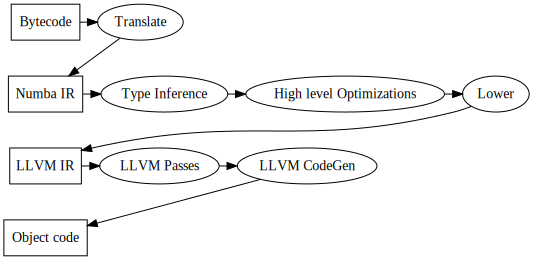

In [23]:
compiler_pipeline

## Translate: Bytecode to Numba IR

### Python bytecode 

* stack based
* implicit fallthrough
* jump by offset or absolute address
* complex instructions
    * e.g. JUMP_IF_TRUE_OR_POP

### Numba IR
* non SSA
* Register-based (infinite)
* Basic-Block

### Translate 
* CFA converts to basic-block
* CFA+DFA converts stack op to register
* DFA assigns variable versions
    * pretends to have scopes
* Heavily relies on heuristics
* Why bytecode? AST relies on source, which may not be available

## Type Inference

* Changes semantic
* Assign a single type to each variable
    * coerce types implicitly (numpy behavior)
* Failure triggers fallback to object mode (unrolled interpreter)
* Function is overloaded

### Effect of variable versioning


In [24]:
@jit
def foo():
    a = 1      # a is int
    bar(a)
    a += 2.5   # a is float
    bar(a)
    a += 2j    # a is complex
    bar(a)
    return a

* ``bar(a)`` is specialized at call-site
* compile time resolved function overloading (mostly)
    * except for call from interpreter
    * C++ overload resolution logic

## High-level optimizations



### Deferred loop specialization

* Only if a function fails type inference
* Loops are extracted into a new function
* Function is again jit-ed
* Runtime types are used to determine types in loop

In [25]:
from numba import jit
from timeit import default_timer

@jit
def foo(arr):
    ts = default_timer()
    c = 0
    for i in arr:
        c += i
    te = default_timer()
    return c, te - ts

In [26]:
import numpy as np
foo(np.arange(10))
foo.inspect_types()

foo (array(int64, 1d, C),)
--------------------------------------------------------------------------------
# File: <ipython-input-25-f52d7c9d9e68>
# --- LINE 4 --- 

@jit

# --- LINE 5 --- 

def foo(arr):

    # --- LINE 6 --- 
    # label 0
    #   arr = arg(0, name=arr)  :: pyobject
    #   $0.1 = global(default_timer: <built-in function perf_counter>)  :: pyobject
    #   $0.2 = call $0.1()  :: pyobject
    #   del $0.1
    #   ts = $0.2  :: pyobject
    #   del $0.2

    ts = default_timer()

    # --- LINE 7 --- 
    #   $const0.3 = const(int, 0)  :: pyobject
    #   c = $const0.3  :: pyobject
    #   del $const0.3

    c = 0

    # --- LINE 8 --- 
    #   jump 18.1
    # label 18.1
    #   $const18.1.1 = const(LiftedLoop, LiftedLoop(<function foo at 0x10c508bf8>))  :: XXX Lifted Loop XXX
    #   $18.1.4 = call $const18.1.1(c, arr)  :: XXX Lifted Loop XXX
    #   del c
    #   del arr
    #   del $const18.1.1
    #   $18.1.6 = exhaust_iter(value=$18.1.4, count=1)  :: pyobject
   

### Array Fusion


* Avoids creating intermediate array 
* Fuse into one loop

In [27]:
from numba import jit, float64

@jit
def axpy(a, x, y):  # all arguments are array
    return a * x + y

axpy.compile((float64[:], float64[:], float64[:]))
axpy.inspect_types()

axpy (array(float64, 1d, A), array(float64, 1d, A), array(float64, 1d, A))
--------------------------------------------------------------------------------
# File: <ipython-input-27-cea9bff9a403>
# --- LINE 3 --- 

@jit

# --- LINE 4 --- 

def axpy(a, x, y):  # all arguments are array

    # --- LINE 5 --- 
    # label 0
    #   a = arg(0, name=a)  :: array(float64, 1d, A)
    #   x = arg(1, name=x)  :: array(float64, 1d, A)
    #   y = arg(2, name=y)  :: array(float64, 1d, A)
    #   $0.5 = arrayexpr(ty=array(float64, 1d, C), expr=('+', [('*', [Var(a, <ipython-input-27-cea9bff9a403> (5)), Var(x, <ipython-input-27-cea9bff9a403> (5))]), Var(y, <ipython-input-27-cea9bff9a403> (5))]))  :: array(float64, 1d, C)
    #   del a
    #   del x
    #   del y
    #   $0.6 = cast(value=$0.5)  :: array(float64, 1d, C)
    #   del $0.5
    #   return $0.6

    return a * x + y




# Lower

* Translate Numba IR to LLVM IR
* Simple ABI
    * only use non-aggregate scalar values for args
    * byval aggregates are expanded into their elements
    * output argument for return
    * exception by return value

## Multi Targets

* Support for CUDA GPUs and HSA APUs
* Target specific intrinsics are exposed

### CUDA

In [28]:
from numba import cuda, float32
import numpy as np

bpg = 5
tpb = 24
n = bpg * tpb

@cuda.jit
def cuda_square_matmul(A, B, C):
    sA = cuda.shared.array(shape=(tpb, tpb), dtype=float32)
    sB = cuda.shared.array(shape=(tpb, tpb), dtype=float32)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y

    x = tx + bx * bw
    y = ty + by * bh

    acc = 0.
    for i in range(bpg):
        if x < n and y < n:
            sA[ty, tx] = A[y, tx + i * tpb]
            sB[ty, tx] = B[ty + i * tpb, x]

        cuda.syncthreads()

        if x < n and y < n:
            for j in range(tpb):
                acc += sA[ty, j] * sB[j, tx]

        cuda.syncthreads()

    if x < n and y < n:
        C[y, x] = acc
        
A = np.array(np.random.random((n, n)), dtype=np.float32)
B = np.array(np.random.random((n, n)), dtype=np.float32)

dA = cuda.to_device(A)
dB = cuda.to_device(B)
dC = cuda.device_array_like(A)

blocks = bpg, bpg
threads = tpb, tpb
cuda_square_matmul[blocks, threads](dA, dB, dC)
C = dC.copy_to_host()
print(C)

[[ 29.6502533   31.63289261  29.12779045 ...,  29.39906311  26.12052917
   30.7340374 ]
 [ 28.13223076  32.86826324  28.57348251 ...,  28.28536224  28.14770889
   31.69555664]
 [ 30.47977066  31.30565453  27.15357399 ...,  29.39358521  28.86541557
   30.84542465]
 ..., 
 [ 31.84250641  34.15019989  32.21094513 ...,  31.32840919  30.13047028
   35.11793518]
 [ 31.37529564  33.70762253  30.18844032 ...,  27.89414978  28.86873436
   31.61554146]
 [ 31.72135162  33.72534943  31.25938034 ...,  28.98091507  30.00896072
   32.70479584]]


### HSA

In [29]:
from numba import hsa

@hsa.jit
def hsa_square_matmul(A, B, C):
    x = hsa.get_global_id(0)
    y = hsa.get_global_id(1)

    tx = hsa.get_local_id(0)
    ty = hsa.get_local_id(1)

    sA = hsa.shared.array(shape=(blocksize, blocksize), dtype=float32)
    sB = hsa.shared.array(shape=(blocksize, blocksize), dtype=float32)

    if x >= C.shape[0] or y >= C.shape[1]:
        return

    tmp = 0

    for i in range(gridsize):
        # preload
        sA[tx, ty] = A[x, ty + i * blocksize]
        sB[tx, ty] = B[tx + i * blocksize, y]
        # wait for preload to end
        hsa.barrier()
        # compute loop
        for j in range(blocksize):
            tmp += sA[tx, j] * sB[j, ty]
        # wait for compute to end
        hsa.barrier()

    C[x, y] = tmp

## How we use LLVM

* Our usecase: LLVM as a library
* Compiler logic in Python
* 1st attempt: binding at C++ layer
    * Hard to maintain
* 2nd attempt: Use a minimal C API

### Communicate by LLVM IR 

* llvmlite
* reimplement IRBuilder in pure python
    * SOLVE: multiple LLVM versions due to custom LLVM for CUDA and HSA

### Custom C-API

* Many LLVM features don't have a C API
* Most LLVM API are designed for extension in C++
    * e.g. callback to pure virtual function
* Not C extension friendly
* Not other language friendly


## Project that uses Numba

* TaxBrian by Open Source Policy Center
    * Let user simulate US economy due to tax policy changes
    * Accelerate economy models
* Bokeh
    * Abstract rendering
    * Compute scene to render
* Many finance related usecases

## Big win from simple compilation technique


## Questions?


#### Contact Us

numba.pydata.org

llvmlite.pydata.org


# Extras

## Near Future of Numba

* Working on support of classes a.k.a JIT classes
* Expanding our Python subset
* Expanding our NumPy API coverage
* AOT compilation

## Numba Memory Management

* Separate RefCt system from Python
* Simple atomic reference count implemented in C
* Determininistic
* Compatible with CPython